In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re

In [2]:
df = pd.read_csv("../../en.openfoodfacts.org.products.tsv", delimiter='\t', encoding='utf-8')

/Users/aaronchan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df.shape

(356027, 163)

In [7]:
pd.set_option('display.max_rows', len(df))
pd.set_option('display.max_columns', 163)
df.head(50)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN

### extract all the nutrient columns

In [13]:
col = df.columns.tolist()
nutrient_list = []

rule1 = re.compile(r'_100g$')
def search_name(x):
    if rule1.search(x) is not None:
        return x
    else:
        return ''

for i in col:
    temp = search_name(i)
    if temp != '':
        nutrient_list = nutrient_list + [temp]

In [16]:
# nutrient_list.remove('nutrition-score-fr_100g')
# nutrient_list.remove('nutrition-score-uk_100g')

In [20]:
# use only 20000 rows temporarily for faster computation
nutrient_df = df.loc[:20000, nutrient_list]

In [21]:
nutrient_df.shape

(20001, 98)

In [27]:
nutrient_df.head()

,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,glycemic-index_100g,water-hardness_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2243.0,NaN,28.57,28.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.018,64.29,14.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6,3.57,NaN,NaN,NaN,0.00000,0.000,NaN,0.0,NaN,NaN,NaN,NaN,0.0214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1941.0,NaN,17.86,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000,60.71,17.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,17.86,NaN,NaN,NaN,0.63500,0.250,NaN,0.0,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2540.0,NaN,57.14,5.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.86,3.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,17.86,NaN,NaN,NaN,1.22428,0.482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.143,NaN,0.00514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1552.0,NaN,1.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
nutrient_df_miss_vals = pd.DataFrame(nutrient_df.isna().mean()).reset_index()
nutrient_df_miss_vals.columns = ["Columns", "MV Rate"]
nutrient_df_miss_vals = miss_vals.sort_values("MV Rate")

/Users/aaronchan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


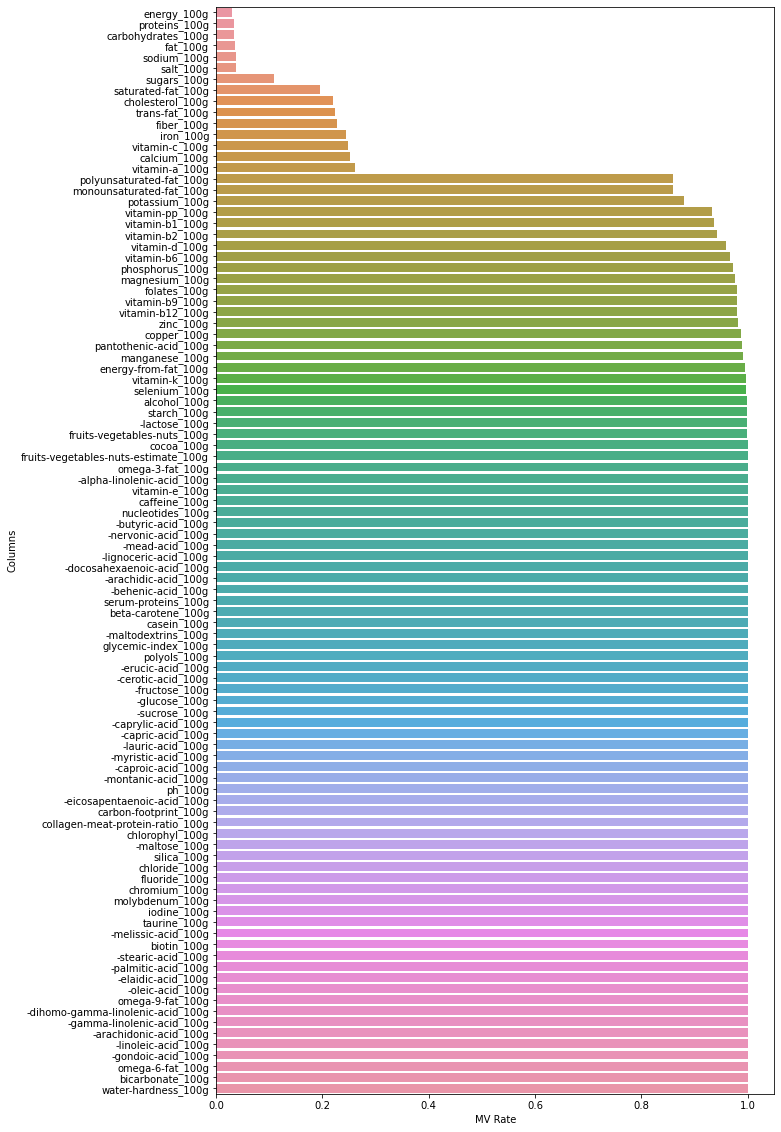

In [40]:
matplotlib.rcParams['figure.figsize'] = [10, 20]

sns.barplot("MV Rate", "Columns", data = nutrient_df_miss_vals, orient = "h")
plt.show()

In [42]:
keep_cols = miss_vals[miss_vals["MV Rate"] < 0.3]["Columns"]

0            energy_100g
49         proteins_100g
38    carbohydrates_100g
2               fat_100g
54           sodium_100g
             ...        
48            fiber_100g
77             iron_100g
61        vitamin-c_100g
75          calcium_100g
56        vitamin-a_100g
Name: Columns, Length: 15, dtype: object

In [44]:
less_missing_nutrient_df = nutrient_df[keep_cols]
less_missing_nutrient_df.head()

,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,sodium_100g,salt_100g,sugars_100g,saturated-fat_100g,cholesterol_100g,trans-fat_100g,fiber_100g,iron_100g,vitamin-c_100g,calcium_100g,vitamin-a_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2243.0,3.57,64.29,28.57,0.000,0.00000,14.29,28.57,0.018,0.0,3.6,0.00129,0.0214,0.000,0.0
2,1941.0,17.86,60.71,17.86,0.250,0.63500,17.86,0.00,0.000,0.0,7.1,0.00129,0.0000,0.071,0.0
3,2540.0,17.86,17.86,57.14,0.482,1.22428,3.57,5.36,NaN,NaN,7.1,0.00514,NaN,0.143,NaN
4,1552.0,8.57,77.14,1.43,NaN,NaN,NaN,NaN,NaN,NaN,5.7,NaN,NaN,NaN,NaN


In [45]:
less_missing_nutrient_df.shape

(20001, 15)

In [71]:
less_missing_nutrient_df.describe()

,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,sodium_100g,salt_100g,sugars_100g,saturated-fat_100g,cholesterol_100g,trans-fat_100g,fiber_100g,iron_100g,vitamin-c_100g,calcium_100g,vitamin-a_100g
count,19388.000000,19320.000000,19318.000000,19302.000000,19257.000000,19257.000000,17838.000000,16087.000000,15608.000000,15540.000000,15450.000000,15117.000000,15037.000000,14963.000000,14780.000000
mean,1115.085403,6.468949,32.595135,12.484011,0.808699,2.054095,16.698567,4.995662,0.019624,0.112249,2.656623,0.003374,0.011128,0.131942,0.000144
std,822.108179,8.291655,29.442481,18.291818,4.637537,11.779343,21.484109,7.828253,0.116848,3.193473,4.343886,0.164507,0.318358,4.280245,0.000601
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326.000000,0.000000,6.450000,0.000000,0.024000,0.060960,1.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1105.000000,3.700000,21.430000,3.570000,0.250000,0.635000,6.670000,1.790000,0.000000,0.000000,1.400000,0.000900,0.000000,0.033000,0.000000
75%,1674.000000,9.260000,60.000000,20.000000,0.595000,1.511300,25.000000,7.140000,0.022000,0.000000,3.600000,0.002250,0.002800,0.107000,0.000107
max,5690.000000,100.000000,100.000000,100.000000,342.857000,870.856780,100.000000,92.860000,13.846000,369.000000,100.000000,19.200000,35.714300,522.727000,0.025714


In [72]:
less_missing_nutrient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy_100g         19388 non-null  float64
 1   proteins_100g       19320 non-null  float64
 2   carbohydrates_100g  19318 non-null  float64
 3   fat_100g            19302 non-null  float64
 4   sodium_100g         19257 non-null  float64
 5   salt_100g           19257 non-null  float64
 6   sugars_100g         17838 non-null  float64
 7   saturated-fat_100g  16087 non-null  float64
 8   cholesterol_100g    15608 non-null  float64
 9   trans-fat_100g      15540 non-null  float64
 10  fiber_100g          15450 non-null  float64
 11  iron_100g           15117 non-null  float64
 12  vitamin-c_100g      15037 non-null  float64
 13  calcium_100g        14963 non-null  float64
 14  vitamin-a_100g      14780 non-null  float64
dtypes: float64(15)
memory usage: 2.3 MB


In [48]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))

In [50]:
otherVariableList = Diff(col, nutrient_list)

In [89]:
# other df

# use only 20000 rows temporarily for faster computation
other_df = df.loc[:, otherVariableList]

In [90]:
other_df_miss_vals = pd.DataFrame(other_df.isna().mean()).reset_index()
other_df_miss_vals.columns = ["Columns", "MV Rate"]
other_df_miss_vals = other_df_miss_vals.sort_values("MV Rate")
other_df_miss_vals

,Columns,MV Rate
8,last_modified_datetime,0.000000
11,last_modified_t,0.000000
3,created_t,0.000008
36,creator,0.000008
5,created_datetime,0.000028
...,...,...
0,allergens_en,0.999944
58,nutrition_grade_uk,1.000000
51,ingredients_from_palm_oil,1.000000
4,ingredients_that_may_be_from_palm_oil,1.000000


In [68]:
other_df_miss_vals = pd.DataFrame(other_df.isna().mean()).reset_index()
other_df_miss_vals.columns = ["Columns", "MV Rate"]
other_df_miss_vals = other_df_miss_vals.sort_values("MV Rate")

/Users/aaronchan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


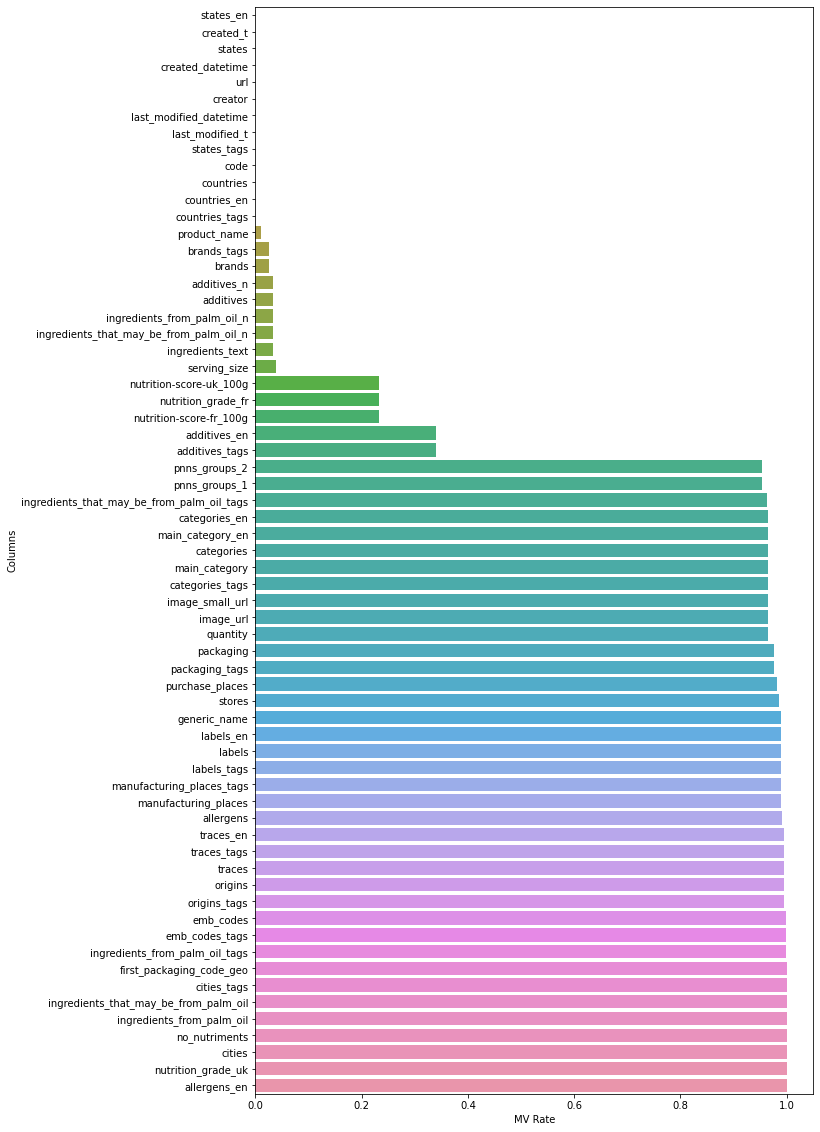

In [69]:
matplotlib.rcParams['figure.figsize'] = [10, 20]

sns.barplot("MV Rate", "Columns", data = other_df_miss_vals, orient = "h")
plt.show()

In [70]:
other_df.head()

,allergens_en,ingredients_that_may_be_from_palm_oil_tags,product_name,created_t,ingredients_that_may_be_from_palm_oil,created_datetime,nutrition-score-fr_100g,emb_codes,last_modified_datetime,cities_tags,packaging_tags,last_modified_t,states_tags,additives_tags,ingredients_text,countries_tags,categories_en,no_nutriments,pnns_groups_2,first_packaging_code_geo,labels_tags,additives,quantity,manufacturing_places,stores,labels,brands,origins_tags,traces,nutrition_grade_fr,allergens,generic_name,packaging,ingredients_from_palm_oil_n,pnns_groups_1,categories,creator,categories_tags,main_category_en,code,image_url,url,ingredients_that_may_be_from_palm_oil_n,purchase_places,cities,labels_en,additives_en,main_category,brands_tags,emb_codes_tags,additives_n,ingredients_from_palm_oil,origins,image_small_url,ingredients_from_palm_oil_tags,serving_size,countries_en,countries,nutrition_grade_uk,traces_tags,nutrition-score-uk_100g,manufacturing_places_tags,states,traces_en,states_en
0,NaN,NaN,Farine de blé noir,1474103866,NaN,2016-09-17T09:17:46Z,NaN,NaN,2016-09-17T09:18:13Z,NaN,NaN,1474103893,"en:to-be-completed,en:nutrition-facts-to-be-co...",NaN,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,1kg,NaN,NaN,NaN,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openfoodfacts-contributors,NaN,NaN,3087,NaN,http://world-en.openfoodfacts.org/product/0000...,NaN,NaN,NaN,NaN,NaN,NaN,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:FR,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...",NaN,"To be completed,Nutrition facts to be complete..."
1,NaN,NaN,Banana Chips Sweetened (Whole),1489069957,NaN,2017-03-09T14:32:37Z,14.0,NaN,2017-03-09T14:32:37Z,NaN,NaN,1489069957,"en:to-be-completed,en:nutrition-facts-complete...",NaN,"Bananas, vegetable oil (coconut oil, corn oil ...",en:united-states,NaN,NaN,NaN,NaN,NaN,[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d,NaN,NaN,NaN,0.0,NaN,NaN,usda-ndb-import,NaN,NaN,4530,NaN,http://world-en.openfoodfacts.org/product/0000...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,28 g (1 ONZ),United States,US,NaN,NaN,14.0,NaN,"en:to-be-completed, en:nutrition-facts-complet...",NaN,"To be completed,Nutrition facts completed,Ingr..."
2,NaN,NaN,Peanuts,1489069957,NaN,2017-03-09T14:32:37Z,0.0,NaN,2017-03-09T14:32:37Z,NaN,NaN,1489069957,"en:to-be-completed,en:nutrition-facts-complete...",NaN,"Peanuts, wheat flour, sugar, rice flour, tapio...",en:united-states,NaN,NaN,NaN,NaN,NaN,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,NaN,NaN,NaN,Torn & Glasser,NaN,NaN,b,NaN,NaN,NaN,0.0,NaN,NaN,usda-ndb-import,NaN,NaN,4559,NaN,http://world-en.openfoodfacts.org/product/0000...,0.0,NaN,NaN,NaN,NaN,NaN,torn-glasser,NaN,0.0,NaN,NaN,NaN,NaN,28 g (0.25 cup),United States,US,NaN,NaN,0.0,NaN,"en:to-be-completed, en:nutrition-facts-complet...",NaN,"To be completed,Nutrition facts completed,Ingr..."
3,NaN,NaN,Organic Salted Nut Mix,1489055731,NaN,2017-03-09T10:35:31Z,12.0,NaN,2017-03-09T10:35:31Z,NaN,NaN,1489055731,"en:to-be-completed,en:nutrition-facts-complete...",NaN,"Organic hazelnuts, organic cashews, organic wa...",en:united-states,NaN,NaN,NaN,NaN,NaN,[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,NaN,NaN,NaN,Grizzlies,NaN,NaN,d,NaN,NaN,NaN,0.0,NaN,NaN,usda-ndb-import,NaN,NaN,16087,NaN,http://world-en.openfoodfacts.org/product/0000...,0.0,NaN,NaN,NaN,NaN,NaN,grizzlies,NaN,0.0,NaN,NaN,NaN,NaN,28 g (0.25 cup),United States,US,NaN,NaN,12.0,NaN,"en:to-be-completed, en:nutrition-facts-complet...",NaN,"To be completed,Nutrition facts completed,Ingr..."
4,NaN,NaN,Organic Polenta,1489055653,NaN,2017-03-09T10:34:13Z,NaN,NaN,2017-03-09T10:34:13Z,NaN,NaN,1489055653,"en:to-be-completed,en:nutrition-facts-complete...",NaN,Organic polenta,en:united-states,NaN,NaN,NaN,NaN,NaN,[ organic-polenta -> en:organic-polenta ] [...,NaN,NaN,NaN,NaN,Bob's Red Mill,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,usda-ndb-import,NaN,NaN,16094,NaN,http://world-en.openfoodfacts.org/product/0000...,0.0,NaN,NaN,NaN,NaN,NaN,bob-s-red

#### by Countries

In [81]:
other_df["countries_en"].unique()

array(['France', 'United States', 'United Kingdom',
       'France,United States', 'Canada', 'Switzerland', 'Spain',
       'Germany', 'Slovenia', 'Bangladesh', 'Italy', 'Romania',
       'Australia', 'Portugal', 'France,United Kingdom',
       'Belgium,France,Netherlands,United Kingdom', 'Guadeloupe',
       'United Kingdom,United States', 'Dominican Republic',
       'Canada,United States', 'Netherlands', 'Australia,France',
       'Canada,France,Switzerland,United States', 'Ireland',
       'France,Réunion', 'Taiwan', 'Australia,Belgium,Switzerland',
       'France,Germany', 'Brazil', 'Belgium,France',
       'Australia,United States', 'Mexico', 'Saudi Arabia',
       'United Arab Emirates', 'Iraq', 'Kuwait', 'Moldova', 'France,Iraq',
       'New Caledonia', nan, 'Singapore', 'Finland',
       'Sweden,United States', 'French Polynesia', 'France,Switzerland',
       'Australia,New Zealand,Singapore,Thailand,United States',
       'France,French Polynesia', 'Panama', 'Costa Rica',
   

In [75]:
other_df["countries_en"].isna().mean()

0.00014999250037498125

In [92]:
other_df.shape

(356027, 65)

In [96]:
country = other_df['countries_en'].value_counts().head(20).to_frame()
country_count = country.style.background_gradient(cmap='Reds')
country_count

161,012

,countries_en
United States,173159
France,123961
Switzerland,14932
Germany,8470
Spain,5529
United Kingdom,5092
Belgium,2936
Australia,2201
Russia,1582
"France,Switzerland",1492


#### by Brands

In [94]:
brands = other_df['brands'].value_counts().head(20).to_frame()
brands_count = brands.style.background_gradient(cmap='Reds')
brands_count

,brands
Carrefour,3670
Auchan,3217
U,2608
Casino,2091
Leader Price,2015
Meijer,1995
Kroger,1662
Cora,1374
Ahold,1370
Spartan,1341


In [79]:
other_df["additives_en"].unique()

array([nan, 'E307c - Tocopherol', 'E322 - Lecithins,E322i - Lecithin',
       ..., 'E339 - Sodium phosphates,E508 - Potassium chloride',
       'E101 - Riboflavin,E101i - Riboflavin,E129 - Allura red ac,E375 - Nicotinic acid',
       'E101 - Riboflavin,E101i - Riboflavin,E129 - Allura red ac,E330 - Citric acid,E375 - Nicotinic acid'],
      dtype=object)

## Need a research question

comparing nutrients by countries?

comparing nutrients by brands?

- Comparing macro nutrients of sugary snacks across countries /on artifical sweetener, natrual sweetener etc.

- Comparing salty snacks across countries on saturated fat, trans fat etc.





# New Idea: cluster macro nutrients by level of nutri-score

https://archpublichealth.biomedcentral.com/articles/10.1186/s13690-019-0357-x

https://get.apicbase.com/nutri-score-science-based-nutritional-value-labelling-system/

In [3]:
nutrientByCountries = ['countries_en', 'main_category', "energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g", "nutrition-score-fr_100g"]
cluster_df = df[nutrientByCountries]
cluster_df = cluster_df.dropna()


In [4]:
cluster_df.shape

(71473, 10)

In [5]:
cluster_df.head()

,countries_en,main_category,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g,nutrition-score-fr_100g
176,Canada,en:plant-based-foods-and-beverages,1210.0,22.00,0.8500,7.000,12.00,23.00,0.000,6.0
182,Canada,en:sugary-snacks,1090.0,3.33,0.2550,2.000,10.70,38.70,24.700,9.0
183,Canada,fr:boulange,1160.0,10.00,0.6000,0.333,1.11,53.30,1.110,1.0
185,France,en:beverages,215.0,0.00,0.0242,0.000,0.00,14.20,13.600,18.0
187,Canada,en:meals,478.0,5.36,0.1960,2.860,6.79,7.86,0.714,2.0


In [21]:
cluster_df["nutrition-score-fr_100g"].describe()

count    71473.000000
mean         8.620612
std          8.956984
min        -15.000000
25%          1.000000
50%          9.000000
75%         15.000000
max         40.000000
Name: nutrition-score-fr_100g, dtype: float64

In [35]:
cluster_df["main_category"].value_counts()[1:25]

en:sugary-snacks               10345
en:beverages                    6813
en:dairies                      6207
en:meats                        3807
en:groceries                    3681
en:fresh-foods                  2913
en:meals                        2503
en:salty-snacks                 2059
en:fruit-juices                 1694
en:frozen-foods                 1548
en:spreads                      1537
en:canned-foods                 1428
en:seafood                      1196
en:desserts                     1172
en:fats                          759
en:sandwiches                    666
en:baby-foods                    478
en:sweeteners                    367
en:fruit-juices-and-nectars      325
en:breakfasts                    295
en:waffles                       230
en:pickles                       198
en:farming-products              182
en:green-olives                  162
Name: main_category, dtype: int64

In [6]:
solidFood = ['en:sugary-snacks', 'en:dairies', 'en:meats',
       'en:groceries', 'en:fresh-foods', 'en:meals', 'en:salty-snacks',
        'en:frozen-foods', 'en:spreads', 'en:canned-foods',
       'en:seafood', 'en:desserts', 'en:fats', 'en:sandwiches',
       'en:baby-foods', 'en:sweeteners', 'en:breakfasts', 'en:waffles', 'en:pickles', 'en:farming-products']

In [39]:
cluster_df['countries_en'].value_counts().head(10)

France                52313
Germany                4613
Spain                  2507
United States          1750
Switzerland            1616
United Kingdom         1408
France,Switzerland      950
Belgium,France          537
Belgium                 502
Australia               452
Name: countries_en, dtype: int64

In [7]:
solidFoodDF = cluster_df[cluster_df.main_category.isin(solidFood)]


In [8]:
solidFoodDF.head()

,countries_en,main_category,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g,nutrition-score-fr_100g
182,Canada,en:sugary-snacks,1090.0,3.33,0.25500,2.00,10.70,38.70,24.700,9.0
187,Canada,en:meals,478.0,5.36,0.19600,2.86,6.79,7.86,0.714,2.0
189,France,en:sugary-snacks,1667.0,0.00,0.00000,0.00,0.00,93.30,93.300,14.0
227,United Kingdom,en:desserts,1284.0,3.90,0.07874,3.60,7.00,54.20,44.000,10.0
228,United Kingdom,en:sugary-snacks,1284.0,3.90,0.07870,3.60,7.00,54.20,44.000,10.0


In [82]:
from IPython.display import Image 
from IPython.core.display import HTML 
Image(url= "https://46vbgn3y13aq29shrj4arjn4-wpengine.netdna-ssl.com/wp-content/uploads/2020/08/Nutri-Score-overview.png",\
      width = 600, height = 800)

In [9]:
solidFoodDF['Nutri-score'] = pd.cut(solidFoodDF['nutrition-score-fr_100g'], [-15, -1, 2, 10, 18, 42],\
                                    labels=['A', 'B', 'C', 'D', 'E'])


<ipython-input-9-5e4e3c1ef281>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solidFoodDF['Nutri-score'] = pd.cut(solidFoodDF['nutrition-score-fr_100g'], [-15, -1, 2, 10, 18, 42],\


In [10]:
solidFoodDF.drop(["countries_en", "nutrition-score-fr_100g"], axis = 1, inplace = True)

/Users/aaronchan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
solidFoodDF.head()

,main_category,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g,Nutri-score
182,en:sugary-snacks,1090.0,3.33,0.25500,2.00,10.70,38.70,24.700,C
187,en:meals,478.0,5.36,0.19600,2.86,6.79,7.86,0.714,B
189,en:sugary-snacks,1667.0,0.00,0.00000,0.00,0.00,93.30,93.300,D
227,en:desserts,1284.0,3.90,0.07874,3.60,7.00,54.20,44.000,C
228,en:sugary-snacks,1284.0,3.90,0.07870,3.60,7.00,54.20,44.000,C


In [41]:
solidFoodClusterDF = solidFoodDF.iloc[:, 1:8]
solidFoodLabelDF = solidFoodDF.iloc[:, [0,8]]

### The "labels"

In [42]:
solidFoodLabelDF = solidFoodLabelDF.reset_index(drop = True)
solidFoodLabelDF

,main_category,Nutri-score
0,en:sugary-snacks,C
1,en:meals,B
2,en:sugary-snacks,D
3,en:desserts,C
4,en:sugary-snacks,C
...,...,...
41566,en:groceries,D
41567,en:groceries,C
41568,en:sugary-snacks,B
41569,en:dairies,D


In [88]:
solidFoodLabelDF["Nutri-score"].value_counts()

D    14408
E     9336
C     8611
B     5857
A     3358
Name: Nutri-score, dtype: int64

### The DF to be clustered

In [43]:
solidFoodClusterDF

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g
182,1090.0,3.330,0.255000,2.00,10.70,38.70,24.700
187,478.0,5.360,0.196000,2.86,6.79,7.86,0.714
189,1667.0,0.000,0.000000,0.00,0.00,93.30,93.300
227,1284.0,3.900,0.078740,3.60,7.00,54.20,44.000
228,1284.0,3.900,0.078700,3.60,7.00,54.20,44.000
...,...,...,...,...,...,...,...
355914,2111.0,1.700,0.689000,3.80,53.30,6.40,5.300
355915,660.0,0.300,0.213000,0.50,6.90,23.10,16.700
355922,1031.0,0.004,0.000394,1.28,1.30,95.31,0.100
355974,13.0,2.000,31.496063,4.00,5.00,58.00,38.000


In [44]:
from sklearn.preprocessing import StandardScaler
X = solidFoodClusterDF
ss = StandardScaler()
scaledX = ss.fit_transform(X)
scaledX= pd.DataFrame(scaledX, columns= solidFoodClusterDF.columns)

In [45]:
scaledX.head()

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g
0,-0.185277,-0.692440,-0.069507,-0.583216,-0.380672,0.479272,0.534516
1,-0.975316,-0.423147,-0.083708,-0.490870,-0.607275,-0.681837,-0.690661
2,0.559579,-1.134186,-0.130885,-0.797974,-1.000787,2.534931,4.038525
3,0.065160,-0.616826,-0.111933,-0.411410,-0.595104,1.062838,1.520338
4,0.065160,-0.616826,-0.111942,-0.411410,-0.595104,1.062838,1.520338


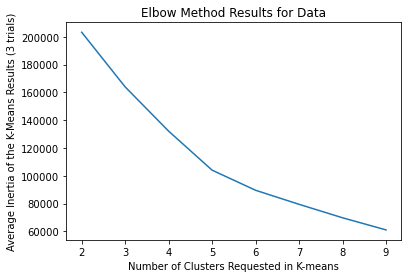

In [46]:
from sklearn.cluster import KMeans

cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(scaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.show()

In [47]:
main_df = pd.concat([scaledX, solidFoodLabelDF], axis = 1)

In [48]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state=1001).fit(scaledX)
main_df['K_means5'] = kmeans.labels_

In [49]:
main_df.head()

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g,main_category,Nutri-score,K_means5
0,-0.185277,-0.692440,-0.069507,-0.583216,-0.380672,0.479272,0.534516,en:sugary-snacks,C,0
1,-0.975316,-0.423147,-0.083708,-0.490870,-0.607275,-0.681837,-0.690661,en:meals,B,0
2,0.559579,-1.134186,-0.130885,-0.797974,-1.000787,2.534931,4.038525,en:sugary-snacks,D,4
3,0.065160,-0.616826,-0.111933,-0.411410,-0.595104,1.062838,1.520338,en:desserts,C,4
4,0.065160,-0.616826,-0.111942,-0.411410,-0.595104,1.062838,1.520338,en:sugary-snacks,C,4


### see what each group consist of 

In [50]:
main_df.loc[main_df['K_means5'] == 0, ]['Nutri-score'].value_counts()

C    5468
B    4900
D    3502
A    2785
E     105
Name: Nutri-score, dtype: int64

In [51]:
main_df.loc[main_df['K_means5'] == 1, ]['Nutri-score'].value_counts()

E    1132
D    1037
C      80
A       9
B       6
Name: Nutri-score, dtype: int64

In [52]:
main_df.loc[main_df['K_means5'] == 2, ]['Nutri-score'].value_counts()

D    1
E    0
C    0
B    0
A    0
Name: Nutri-score, dtype: int64

In [53]:
main_df.loc[main_df['K_means5'] == 2, ]

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g,main_category,Nutri-score,K_means5
41282,1.345745,-0.099465,178.467682,0.65164,0.969672,0.964949,-0.624974,en:groceries,D,2


In [55]:
main_df.loc[main_df['K_means5'] == 3, ]['Nutri-score'].value_counts()

D    4383
C    1862
E    1597
B     782
A     476
Name: Nutri-score, dtype: int64

In [56]:
main_df.loc[main_df['K_means5'] == 4, ]['Nutri-score'].value_counts()

E    6502
D    5486
C    1201
B     169
A      88
Name: Nutri-score, dtype: int64

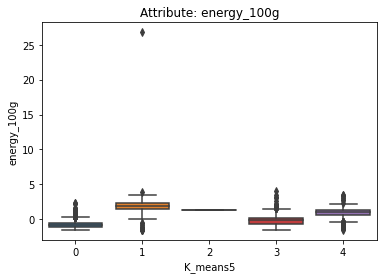

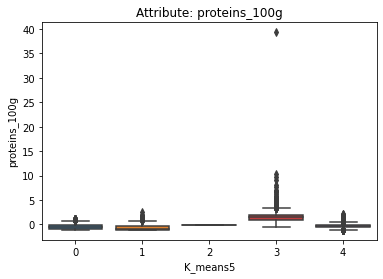

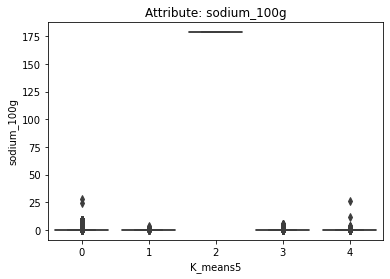

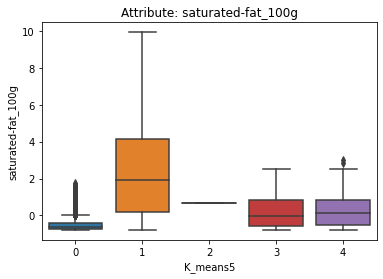

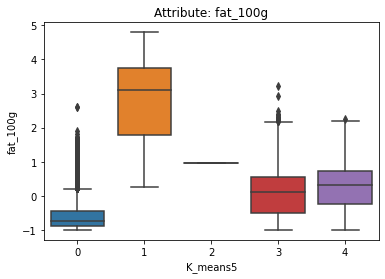

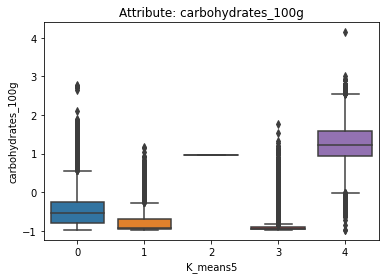

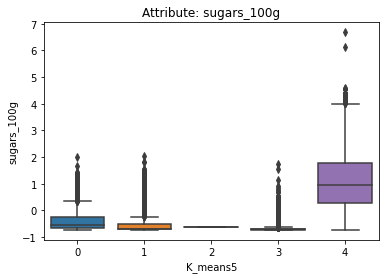

In [144]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='K_means5', y=col, data=main_df)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

### Drop that row with exceptional high sodium

In [96]:
data.shape

(41571, 7)

In [58]:
main_df = main_df.drop(index=41282, )

In [61]:
main_df.head()

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g,main_category,Nutri-score,K_means5
0,-0.185277,-0.692440,-0.069507,-0.583216,-0.380672,0.479272,0.534516,en:sugary-snacks,C,0
1,-0.975316,-0.423147,-0.083708,-0.490870,-0.607275,-0.681837,-0.690661,en:meals,B,0
2,0.559579,-1.134186,-0.130885,-0.797974,-1.000787,2.534931,4.038525,en:sugary-snacks,D,4
3,0.065160,-0.616826,-0.111933,-0.411410,-0.595104,1.062838,1.520338,en:desserts,C,4
4,0.065160,-0.616826,-0.111942,-0.411410,-0.595104,1.062838,1.520338,en:sugary-snacks,C,4


In [76]:
scaledX = main_df.iloc[:, 0:7]
solidFoodLabelDF = main_df.iloc[:, [7,8]]

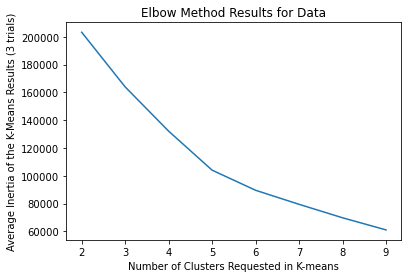

In [70]:
from sklearn.cluster import KMeans

cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(scaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.show()

In [77]:
main_df2 = pd.concat([scaleX, solidFoodLabelDF], axis = 1)

In [80]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state=1001).fit(scaledX)
main_df2['K_means5'] = kmeans.labels_

In [81]:
main_df2.head()

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g,main_category,Nutri-score,K_means5
0,-0.185277,-0.692440,-0.069507,-0.583216,-0.380672,0.479272,0.534516,en:sugary-snacks,C,1
1,-0.975316,-0.423147,-0.083708,-0.490870,-0.607275,-0.681837,-0.690661,en:meals,B,1
2,0.559579,-1.134186,-0.130885,-0.797974,-1.000787,2.534931,4.038525,en:sugary-snacks,D,4
3,0.065160,-0.616826,-0.111933,-0.411410,-0.595104,1.062838,1.520338,en:desserts,C,4
4,0.065160,-0.616826,-0.111942,-0.411410,-0.595104,1.062838,1.520338,en:sugary-snacks,C,4


In [82]:
main_df2.loc[main_df2['K_means5'] == 0, ]['Nutri-score'].value_counts()

E    6356
D    3972
C    1046
B     161
A      91
Name: Nutri-score, dtype: int64

In [83]:
main_df2.loc[main_df2['K_means5'] == 1, ]['Nutri-score'].value_counts()

C    5476
B    4906
D    3447
A    2787
E      80
Name: Nutri-score, dtype: int64

In [84]:
main_df2.loc[main_df2['K_means5'] == 2, ]['Nutri-score'].value_counts()

D    4401
C    1857
E    1596
B     779
A     475
Name: Nutri-score, dtype: int64

In [85]:
main_df2.loc[main_df2['K_means5'] == 3, ]['Nutri-score'].value_counts()

E    907
D    756
C     71
B      6
A      5
Name: Nutri-score, dtype: int64

In [86]:
main_df2.loc[main_df2['K_means5'] == 4, ]['Nutri-score'].value_counts()

D    1832
E     397
C     161
B       5
A       0
Name: Nutri-score, dtype: int64

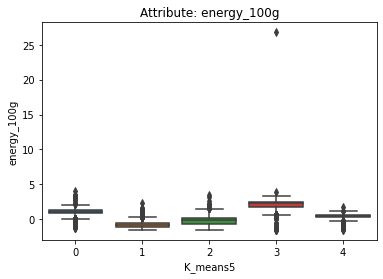

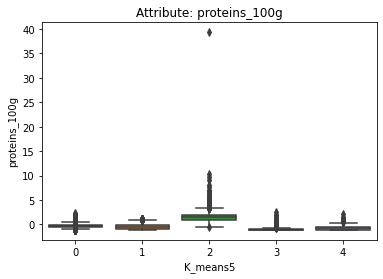

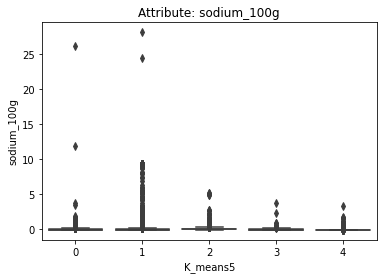

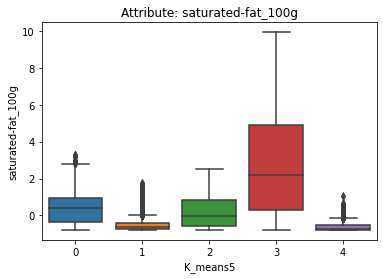

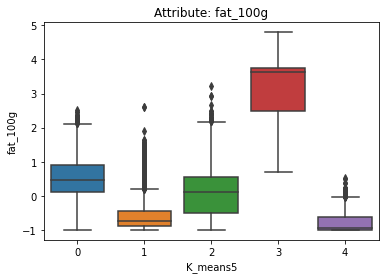

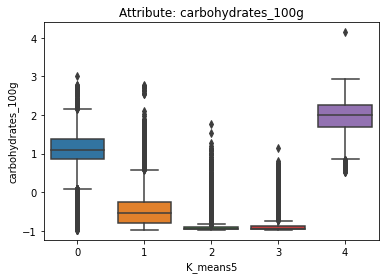

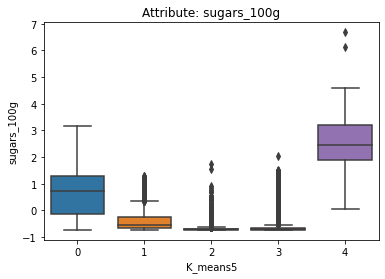

In [89]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='K_means5', y=col, data=main_df2)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

## Try RobustScaler()

In [97]:
solidFoodClusterDF = solidFoodDF.iloc[:, 1:8]
solidFoodLabelDF = solidFoodDF.iloc[:, [0,8]]

In [108]:
solidFoodLabelDF = solidFoodLabelDF.reset_index()

In [101]:
from sklearn.preprocessing import RobustScaler
trans = RobustScaler(quantile_range=(0.05, 0.95))

robustScaledX = trans.fit_transform(solidFoodClusterDF)
robustScaledX = pd.DataFrame(robustScaledX, columns= solidFoodClusterDF.columns)

In [109]:
main_df3 = pd.concat([robustScaledX, solidFoodLabelDF], axis = 1)

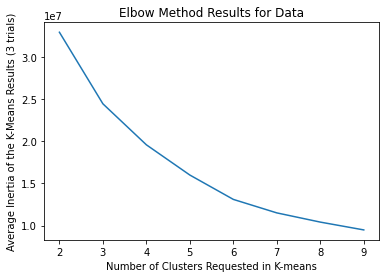

In [111]:
from sklearn.cluster import KMeans

cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(robustScaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.show()

In [113]:
kmeans = KMeans(n_clusters = 4, random_state=1001).fit(robustScaledX)
main_df3['K_means4'] = kmeans.labels_

In [114]:
main_df3.loc[main_df3['K_means4'] == 0, ]['Nutri-score'].value_counts()

D    3066
E    1900
C     169
A      35
B      14
Name: Nutri-score, dtype: int64

In [115]:
main_df3.loc[main_df3['K_means4'] == 1, ]['Nutri-score'].value_counts()

E    6265
D    4061
C    1228
B     351
A     129
Name: Nutri-score, dtype: int64

In [116]:
main_df3.loc[main_df3['K_means4'] == 2, ]['Nutri-score'].value_counts()

C    7125
D    5596
B    5492
A    3194
E     754
Name: Nutri-score, dtype: int64

In [117]:
main_df3.loc[main_df3['K_means4'] == 3, ]['Nutri-score'].value_counts()

D    1686
E     417
C      89
B       0
A       0
Name: Nutri-score, dtype: int64

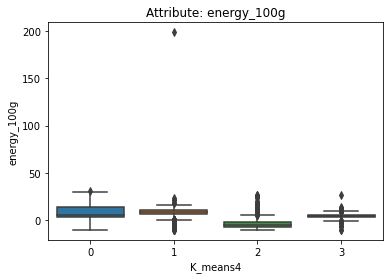

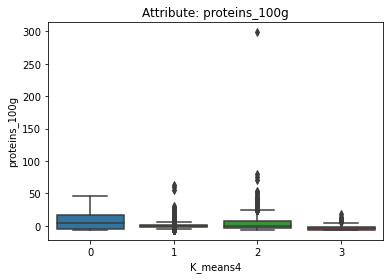

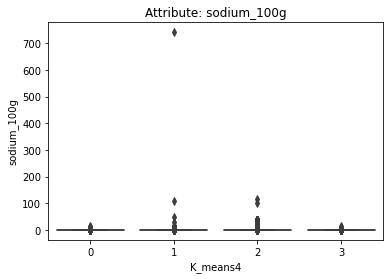

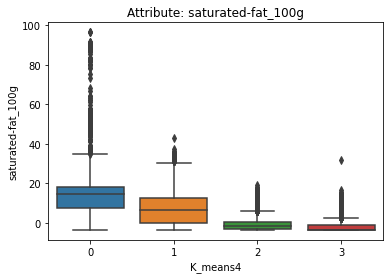

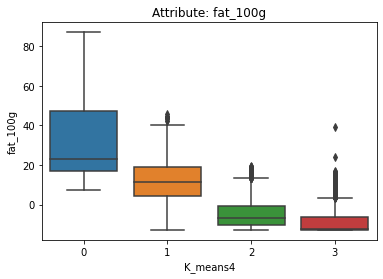

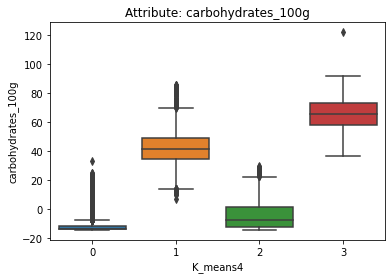

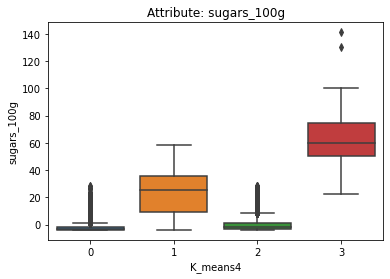

In [118]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='K_means4', y=col, data=main_df3)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

### hierarchical4

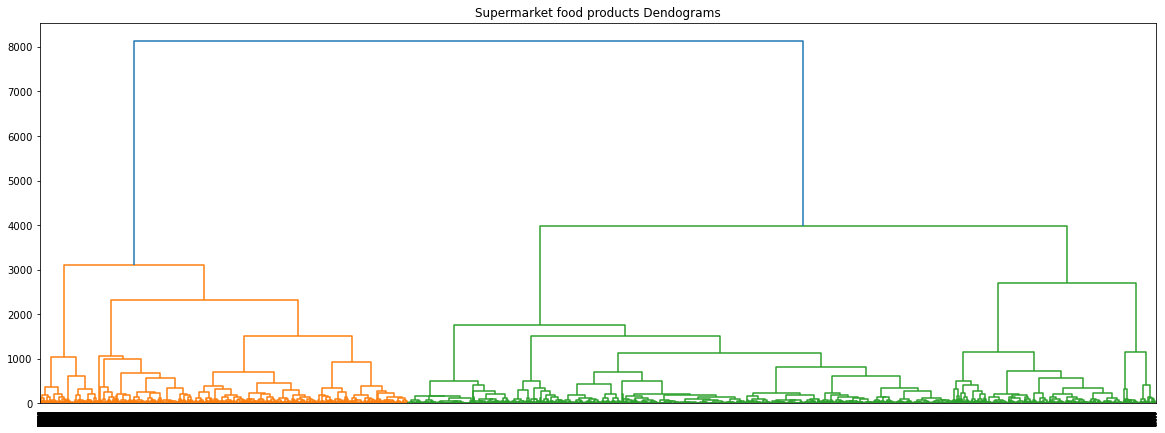

In [119]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 7))
plt.title("Supermarket food products Dendograms")
plt.xticks(rotation='vertical')


dend = shc.dendrogram(shc.linkage(robustScaledX, method='ward'))

In [120]:
agc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward')

main_df3['hierarchical4'] = agc.fit_predict(robustScaledX)


In [121]:
main_df3.loc[main_df3['hierarchical4'] == 0, ]['Nutri-score'].value_counts ()

D    4482
E    2368
C     579
B      75
A      53
Name: Nutri-score, dtype: int64

In [122]:
main_df3.loc[main_df3['hierarchical4'] == 1, ]['Nutri-score'].value_counts ()

E    6148
D    3715
C    1153
B     352
A     123
Name: Nutri-score, dtype: int64

In [123]:
main_df3.loc[main_df3['hierarchical4'] == 2, ]['Nutri-score'].value_counts ()

C    6759
B    5430
D    4489
A    3182
E     462
Name: Nutri-score, dtype: int64

In [124]:
main_df3.loc[main_df3['hierarchical4'] == 3, ]['Nutri-score'].value_counts ()

D    1723
E     358
C     120
B       0
A       0
Name: Nutri-score, dtype: int64

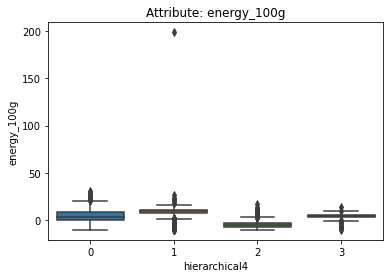

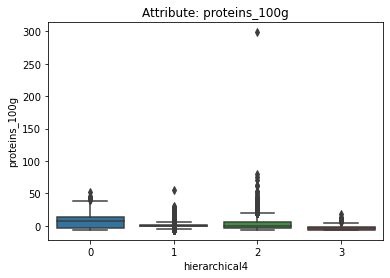

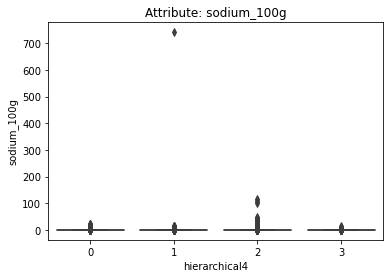

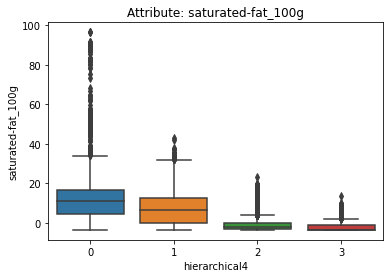

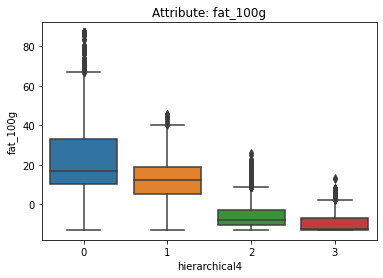

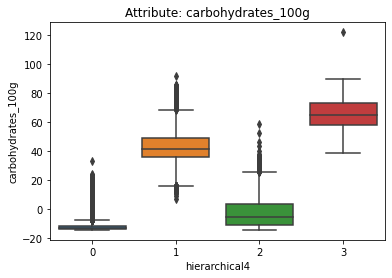

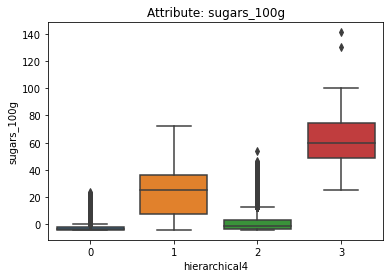

In [125]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='hierarchical4', y=col, data=main_df3)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

In [126]:
sum(main_df3['hierarchical4'] == main_df3['K_means4'] )

38097

In [127]:
len(main_df3['hierarchical4'])

41571

## Unsupervised Learning

In [11]:
print(df.columns.tolist())

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

In [29]:
nutrientByCountries_wcategory = ['countries_en', 'main_category', "energy_100g","proteins_100g","sodium_100g", \
             "fat_100g","carbohydrates_100g","sugars_100g"]
cluster_df_wcategory = df[nutrientByCountries_wcategory]
cluster_df_wcategory = cluster_df_wcategory.dropna()

In [37]:
cluster_df_wcategory['countries_en'].value_counts().head(10)

France                53157
Germany                4664
Spain                  2554
United States          2118
Switzerland            1662
United Kingdom         1423
France,Switzerland      977
Belgium,France          556
Belgium                 515
Australia               460
Name: countries_en, dtype: int64

In [38]:
cluster_df_wcategory = cluster_df_wcategory[cluster_df_wcategory.countries_en.isin(['United States', 'France', 'Switzerland',\
                                                 'Spain', 'United Kingdom', 'Belgium', 'Italy', 'Portugal',\
                                                     'Netherlands', 'Sweden', 'Germany'])]


In [39]:
cluster_df_wcategory.head()

,countries_en,main_category,energy_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,sugars_100g
185,France,en:beverages,215.0,0.0,0.024200,0.0,14.2,13.6
189,France,en:sugary-snacks,1667.0,0.0,0.000000,0.0,93.3,93.3
190,France,en:beverages,17.0,0.1,0.000394,0.1,0.1,0.1
223,Germany,en:plant-based-foods-and-beverages,2257.0,4.7,0.035433,33.3,53.8,51.5
227,United Kingdom,en:desserts,1284.0,3.9,0.078740,7.0,54.2,44.0


In [50]:
cluster_df_wcategory['main_category'].unique().tolist()

['en:beverages',
 'en:sugary-snacks',
 'en:plant-based-foods-and-beverages',
 'en:desserts',
 'en:groceries',
 'en:dietary-supplements',
 'en:chips-and-fries',
 'en:spreads',
 'en:meals',
 'en:carrot-coriander-soup',
 'en:salty-snacks',
 'en:meats',
 'en:dairies',
 'en:crepes-and-galettes',
 'en:fats',
 'en:parve',
 'en:pates-a-tartiner-aux-noisettes-et-au-cacao',
 'en:fish-and-meat-and-eggs',
 'en:salad',
 'en:fruit-juices',
 'en:hoisin-sauce',
 'en:rice-candy',
 'en:pies',
 'en:diet-colas',
 'en:tea-drinks',
 'en:semolina',
 'en:seafood',
 'en:snacks',
 'en:steak-pie',
 'en:lemongrass-paste',
 'en:cake-mix',
 'en:mashed-potatoes',
 'en:granola-mix',
 'en:mix',
 'en:breakfasts',
 'en:sweeteners',
 'en:olives',
 'en:bison',
 'en:farming-products',
 'en:preparation-for-dessert',
 'en:beef-jerky',
 'en:peels',
 'en:carbonated-soda-water',
 'en:banana-nut-loaf',
 'en:pitta-bread',
 'en:frozen-foods',
 'en:balsamic-vinaigrette-dressing',
 'en:macaroni-cheese',
 'en:macaroni',
 'en:penne',


## Category: Baverages

In [62]:
beverages_df = cluster_df_wcategory[cluster_df_wcategory.main_category == "en:beverages"]

In [63]:
beverages_df.shape

(6733, 8)

In [64]:
beverages_df['countries_en'].value_counts().head(10)

France            5680
Germany            285
United States      228
Spain              191
Switzerland        185
Belgium             55
United Kingdom      49
Sweden              18
Netherlands         17
Italy               16
Name: countries_en, dtype: int64

In [65]:
US_German = beverages_df[(beverages_df.countries_en == "United States" )| (beverages_df.countries_en == "Germany")]

In [66]:
US_German.head()

,countries_en,main_category,energy_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,sugars_100g
1665,United States,en:beverages,117.0,0.0,0.017,0.0,7.60,7.60
1666,United States,en:beverages,117.0,0.0,0.017,0.0,7.60,7.60
3828,United States,en:beverages,192.0,0.0,0.015,0.0,10.83,9.58
4434,United States,en:beverages,192.0,0.0,0.015,0.0,10.83,9.58
6787,United States,en:beverages,50.0,0.0,0.015,0.0,3.33,3.33


/Users/aaronchan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sugars_100g', ylabel='fat_100g'>

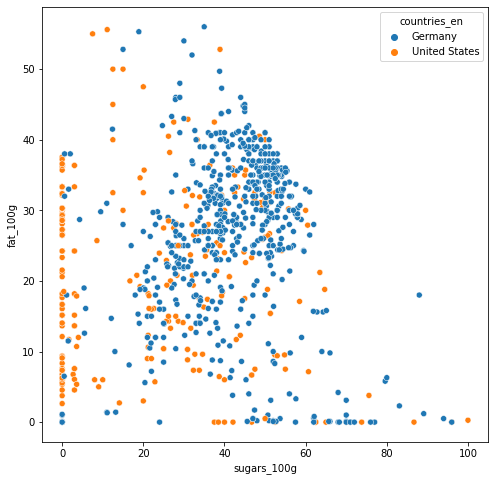

In [58]:
plt.figure(figsize=(8, 8))
sns.scatterplot('sugars_100g', 'fat_100g', data = US_German, hue = 'countries_en')

In [73]:
US_German.shape

(513, 8)

## Category: sugary-snacks

In [45]:
sugarysnacks_df = cluster_df_wcategory[cluster_df_wcategory.main_category == "en:sugary-snacks"]

In [46]:
sugarysnacks_df.shape

(9295, 8)

In [67]:
sugarysnacks_df.head()

,countries_en,main_category,energy_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,sugars_100g
189,France,en:sugary-snacks,1667.0,0.0,0.000000,0.0,93.3,93.3
228,United Kingdom,en:sugary-snacks,1284.0,3.9,0.078700,7.0,54.2,44.0
251,France,en:sugary-snacks,1900.0,6.0,0.259843,23.0,55.0,26.0
288,France,en:sugary-snacks,1768.0,5.8,0.255906,19.0,56.0,28.0
292,France,en:sugary-snacks,1670.0,4.9,0.236220,15.0,60.0,34.0


In [60]:
sugarysnacks_df['countries_en'].value_counts().head(10)

France            7308
Germany            634
Spain              377
United States      355
Switzerland        222
United Kingdom     189
Belgium             79
Portugal            55
Sweden              37
Netherlands         32
Name: countries_en, dtype: int64

/Users/aaronchan/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


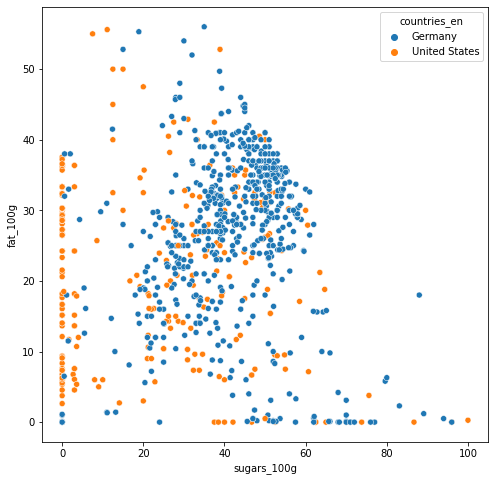

In [71]:
US_German_sugarysnacks = sugarysnacks_df[(sugarysnacks_df.countries_en == "United States" )| (sugarysnacks_df.countries_en == "Germany")]

plt.figure(figsize=(8, 8))
sns.scatterplot('sugars_100g', 'fat_100g', data = US_German_sugarysnacks, hue = 'countries_en')
plt.show()

In [72]:
US_German_sugarysnacks.shape

(989, 8)

## Category: salty-snacks

In [52]:
saltysnacks_df = cluster_df_wcategory[cluster_df_wcategory.main_category == "en:salty-snacks"]

In [53]:
saltysnacks_df.shape

(1851, 8)

In [54]:
saltysnacks_df['countries_en'].value_counts().head(10)

France            1529
Germany             78
United States       63
Switzerland         45
United Kingdom      45
Spain               36
Italy               23
Belgium             16
Netherlands          7
Sweden               7
Name: countries_en, dtype: int64

In [ ]:
salty-snacks

## below is macro nutrient

In [43]:
nutrientByCountries = ['countries_en', "energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]
cluster_df = df[nutrientByCountries]
cluster_df = cluster_df.dropna()


In [44]:
cluster_df['countries_en'].value_counts().head(16)

United States            138765
France                    73982
Switzerland                8865
Germany                    4843
Spain                      2589
United Kingdom             1526
France,Switzerland         1309
Belgium,France              635
Belgium                     605
Australia                   496
Italy                       374
France,United Kingdom       343
Portugal                    342
France,Germany              275
Netherlands                 252
Sweden                      252
Name: countries_en, dtype: int64

In [45]:
cluster_df = cluster_df[cluster_df.countries_en.isin(['United States', 'France', 'Switzerland',\
                                                'Germany', 'Spain', 'United Kingdom', 'Belgium', 'Italy', 'Portugal',\
                                                     'Netherlands', 'Sweden'])]

cluster_df['countries_en'] = ['US' if c == 'United States' else 'EU' for c in cluster_df['countries_en']]


In [46]:
cluster_df.head()

,countries_en,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g
1,US,2243.0,3.57,0.000,28.57,28.57,64.29,14.29
2,US,1941.0,17.86,0.250,0.00,17.86,60.71,17.86
3,US,2540.0,17.86,0.482,5.36,57.14,17.86,3.57
7,US,1833.0,14.06,0.055,4.69,18.75,57.81,15.62
12,US,2230.0,16.67,0.633,5.00,36.67,36.67,3.33


In [82]:
label = cluster_df.iloc[:, 0]

In [83]:
label

1         US
2         US
3         US
7         US
12        US
          ..
355981    EU
355985    US
356005    EU
356017    EU
356022    US
Name: countries_en, Length: 232395, dtype: object

In [49]:
toCluster_df = cluster_df.iloc[:, 1:]

In [50]:
from sklearn.preprocessing import StandardScaler
X = toCluster_df
ss = StandardScaler()
scaledX = ss.fit_transform(toCluster_df)
scaledX= pd.DataFrame(scaledX, columns= toCluster_df.columns)

## Try TSNE to see if there is any signal

In [96]:
from sklearn.manifold import TSNE

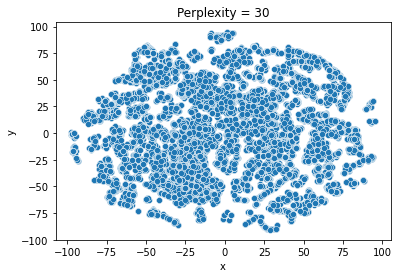

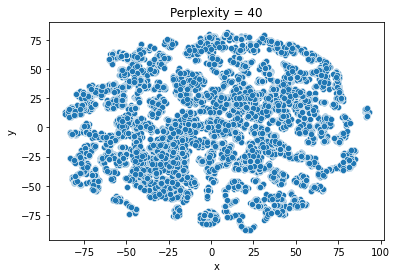

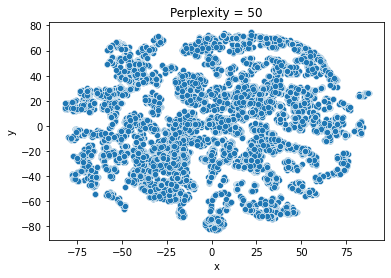

In [90]:
from sklearn.manifold import TSNE

perplexity = [30,40,50]
for p in perplexity:
    tsne = TSNE(n_components=2, perplexity=p, random_state= 1001)
    data_tsne = tsne.fit_transform(scaledX)

    # #concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
    df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=X.index)
    dff = pd.concat([X, df_tsne], axis=1)

    # Plot the projected (x,y) coordinates
    sns.scatterplot(x='x', y='y', data=dff)
    plt.title('Perplexity = '+ str(p) )
    plt.show()

In [97]:
tsne = TSNE(n_components=2, perplexity = 60, random_state= 1001)
data_tsne = tsne.fit_transform(scaledX)

# #concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['tsne_x', 'tsne_y'], index=X.index)
dff = pd.concat([dff, df_tsne], axis=1)



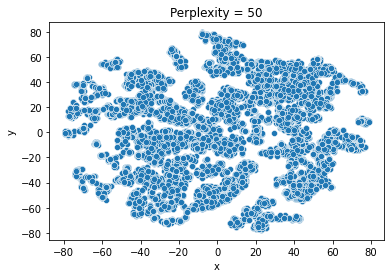

In [128]:
sns.scatterplot(x='x', y='y', data=dff)
plt.title('Perplexity = '+ str(p) )
plt.show()

In [129]:
dff['Country'] = label

In [130]:
label.value_counts()

US    138765
EU     93630
Name: countries_en, dtype: int64

In [131]:
dff.head()

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g,x,y,Country
1,2243.0,3.57,0.000,28.57,28.57,64.29,14.29,64.853935,44.052582,US
2,1941.0,17.86,0.250,0.00,17.86,60.71,17.86,49.863964,10.787164,US
3,2540.0,17.86,0.482,5.36,57.14,17.86,3.57,27.914677,-68.044266,US
7,1833.0,14.06,0.055,4.69,18.75,57.81,15.62,48.861397,10.070470,US
12,2230.0,16.67,0.633,5.00,36.67,36.67,3.33,28.730707,-55.497120,US


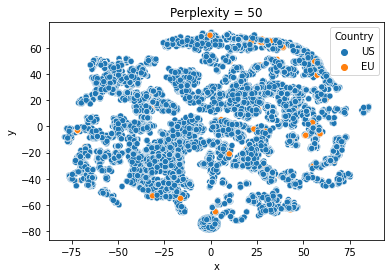

In [99]:
# Plot the projected (x,y) coordinates
sns.scatterplot(x='x', y='y', data=dff, hue = 'Country')
plt.title('Perplexity = '+ str(p) )
plt.show()

UMAP

In [16]:
import umap.umap_ as umap

In [19]:
reducer = umap.UMAP(random_state=42, min_dist=0.1, n_components=2, n_neighbors=10)
reducer.fit(scaledX)
embedding = reducer.transform(scaledX)

In [20]:
embedding

array([[ -5.96499   ,  -2.2495515 ],
       [ -0.11830407,  -0.24892844],
       [ -7.3297    ,   8.283033  ],
       ...,
       [ -4.664654  ,   4.507858  ],
       [  9.780476  ,  -2.469605  ],
       [-16.766294  ,   0.6965156 ]], dtype=float32)

In [51]:
df_umap = pd.DataFrame(embedding, columns=['x', 'y'], index=scaledX.index)
dff = pd.concat([scaledX, df_umap], axis=1)

In [23]:
df_umap.to_csv("umapEmbedding.csv")

## Try Kmeans

In [52]:
scaledX.head()

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g
0,1.402100,-0.514427,-0.012113,3.198726,0.937152,1.127943,-0.022149
1,1.007749,1.228861,-0.007375,-0.658232,0.279486,1.001324,0.159222
2,1.789922,1.228861,-0.002978,0.065369,2.691543,-0.514211,-0.566770
3,0.866723,0.765285,-0.011071,-0.025081,0.334138,0.898756,0.045420
4,1.385124,1.083688,-0.000116,0.016769,1.434547,0.151068,-0.578963


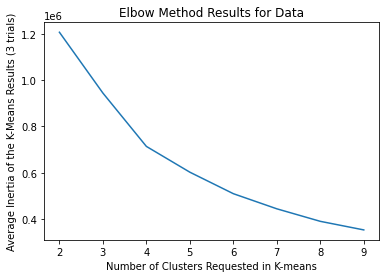

In [14]:
from sklearn.cluster import KMeans

cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(scaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.show()

In [39]:
dff["country"] = label

#### See elbow at K = 4

In [54]:
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters = 4, random_state=1001).fit(scaledX)
dff['K_means4'] = kmeans.labels_

In [107]:
dff.head()

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g,x,y,K_means4,country,tsne_x,tsne_y
0,1.402100,-0.514427,-0.012113,3.198726,0.937152,1.127943,-0.022149,-5.964990,-2.249552,0.0,US,-16.141918,2.923762
1,1.007749,1.228861,-0.007375,-0.658232,0.279486,1.001324,0.159222,-0.118304,-0.248928,3.0,US,21.877756,-21.732784
2,1.789922,1.228861,-0.002978,0.065369,2.691543,-0.514211,-0.566770,-7.329700,8.283033,0.0,US,-31.098654,-34.418396
3,0.866723,0.765285,-0.011071,-0.025081,0.334138,0.898756,0.045420,-0.847313,0.192598,3.0,US,18.298731,-24.396217
4,1.385124,1.083688,-0.000116,0.016769,1.434547,0.151068,-0.578963,-4.775989,-1.518063,0.0,US,-18.030775,-11.422819


In [84]:
label = label.reset_index(drop = True)

In [86]:
dff["country"] = label

In [88]:
dff.loc[dff['K_means4'] == 0, ]['country'].value_counts()

US    24736
EU    16529
Name: country, dtype: int64

In [89]:
dff.loc[dff['K_means4'] == 1, ]['country'].value_counts()

US    1
Name: country, dtype: int64

In [90]:
dff.loc[dff['K_means4'] == 2, ]['country'].value_counts()

US    62158
EU    49481
Name: country, dtype: int64

In [91]:
dff.loc[dff['K_means4'] == 3, ]['country'].value_counts()

US    51870
EU    27620
Name: country, dtype: int64

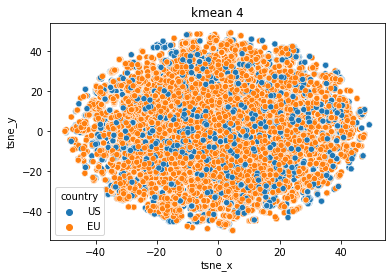

In [108]:
# Plot the projected (x,y) coordinates
sns.scatterplot(x='tsne_x', y='tsne_y', data=dff, hue = 'country')
plt.title('kmean 4')
plt.show()

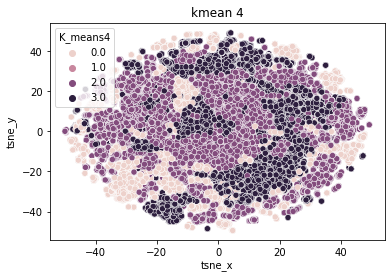

In [109]:
# Plot the projected (x,y) coordinates
sns.scatterplot(x='tsne_x', y='tsne_y', data=dff, hue = 'K_means4')
plt.title('kmean 4')
plt.show()

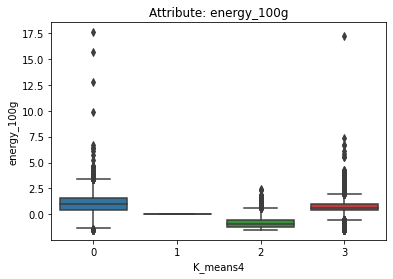

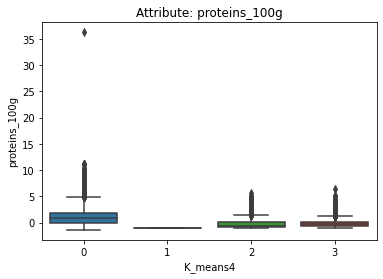

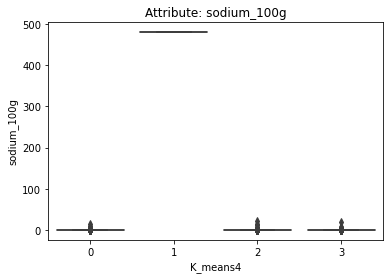

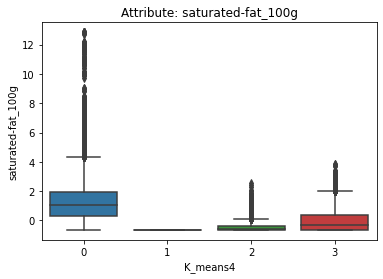

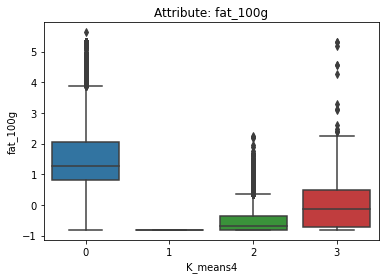

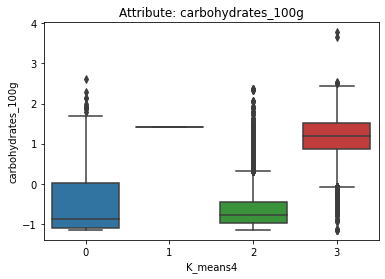

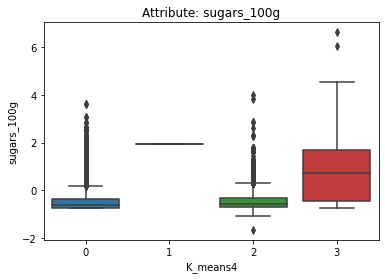

In [94]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='K_means4', y=col, data=dff)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

### Another attempt of Marco Netrient but with categories

In [139]:
nutrientByCountries = ['countries_en','main_category', "energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]
cluster_df = df[nutrientByCountries]
cluster_df = cluster_df.dropna()

In [140]:
cluster_df['countries_en'].value_counts().head(16)

France                   53041
Germany                   4653
Spain                     2536
United States             1756
Switzerland               1629
United Kingdom            1417
France,Switzerland         974
Belgium,France             555
Belgium                    510
Australia                  454
France,United Kingdom      324
Italy                      317
Portugal                   291
France,Germany             264
Sweden                     235
Serbia                     225
Name: countries_en, dtype: int64

In [141]:
cluster_df = cluster_df[cluster_df.countries_en.isin(['United States', 'France', 'Switzerland',\
                                                'Germany', 'Spain', 'United Kingdom', 'Belgium', 'Italy', 'Portugal',\
                                                     'Netherlands', 'Sweden'])]

#cluster_df['countries_en'] = ['US' if c == 'United States' else 'EU' for c in cluster_df['countries_en']]


In [142]:
cluster_df.head()

,countries_en,main_category,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g
185,France,en:beverages,215.0,0.0,0.024200,0.0,0.0,14.2,13.6
189,France,en:sugary-snacks,1667.0,0.0,0.000000,0.0,0.0,93.3,93.3
190,France,en:beverages,17.0,0.1,0.000394,0.1,0.1,0.1,0.1
223,Germany,en:plant-based-foods-and-beverages,2257.0,4.7,0.035433,21.1,33.3,53.8,51.5
227,United Kingdom,en:desserts,1284.0,3.9,0.078740,3.6,7.0,54.2,44.0


In [155]:
Countrylabel = cluster_df.iloc[:, 0]
Categorylabel = cluster_df.iloc[:, 1]

In [143]:
toCluster_df = cluster_df.iloc[:, 2:]

In [146]:
from sklearn.preprocessing import StandardScaler
X = toCluster_df
ss = StandardScaler()
scaledX = ss.fit_transform(toCluster_df)
scaledX= pd.DataFrame(scaledX, columns= toCluster_df.columns)

In [147]:
X = X.iloc[:20000, :]
scaledX = scaledX.iloc[:20000, :]

In [148]:
tsne = TSNE(n_components=2, perplexity = 60, random_state= 1001)
data_tsne = tsne.fit_transform(scaledX)

# #concatenate the projected (x,y) coordinates (df_tsne) and the original dataset (df) into the same dataset.
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=X.index)
dff = pd.concat([X, df_tsne], axis=1)



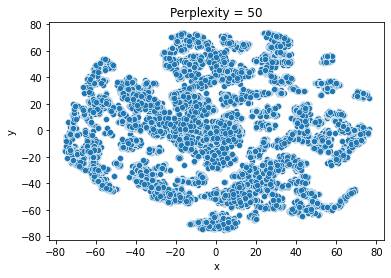

In [149]:
sns.scatterplot(x='x', y='y', data=dff)
plt.title('Perplexity = '+ str(p) )
plt.show()

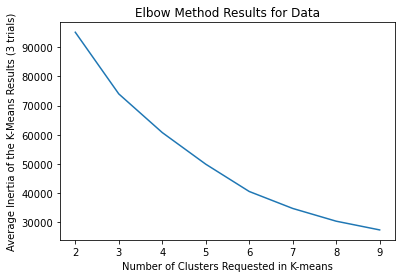

In [150]:
cluster_num_list=range(2,10)
avg_inertia_list=[]
for k in cluster_num_list:
    sub_inertia_list=[]
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(scaledX)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

#Plot it    
plt.plot(cluster_num_list,avg_inertia_list)
plt.xlabel('Number of Clusters Requested in K-means')
plt.ylabel('Average Inertia of the K-Means Results (3 trials)')
plt.title('Elbow Method Results for Data')
plt.show()

In [159]:
dff['Country'] = Countrylabel
dff['Category'] = Categorylabel

In [161]:
dff.head()

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g,x,y,Country,Category
185,215.0,0.0,0.024200,0.0,0.0,14.2,13.6,-61.980404,-35.660824,France,en:beverages
189,1667.0,0.0,0.000000,0.0,0.0,93.3,93.3,65.156815,-49.776329,France,en:sugary-snacks
190,17.0,0.1,0.000394,0.1,0.1,0.1,0.1,-56.147896,46.430004,France,en:beverages
223,2257.0,4.7,0.035433,21.1,33.3,53.8,51.5,3.179718,-72.167648,Germany,en:plant-based-foods-and-beverages
227,1284.0,3.9,0.078740,3.6,7.0,54.2,44.0,33.982281,-42.275620,United Kingdom,en:desserts


elbow at K = 3 and K = 6

In [162]:
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=3, random_state=1001).fit(scaledX)
dff['K_means3'] = kmeans.labels_

In [163]:

kmeans=KMeans(n_clusters=6, random_state=1001).fit(scaledX)
dff['K_means6'] = kmeans.labels_

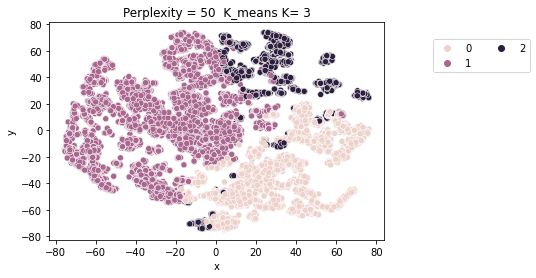

In [165]:
sns.scatterplot(x='x', y='y', hue= 'K_means3', data=dff)
plt.title('Perplexity = '+ str(50) + '  K_means K= 3' )
plt.legend(loc= 'lower right', ncol= 2,bbox_to_anchor=(1.45, 0.75))
plt.show()

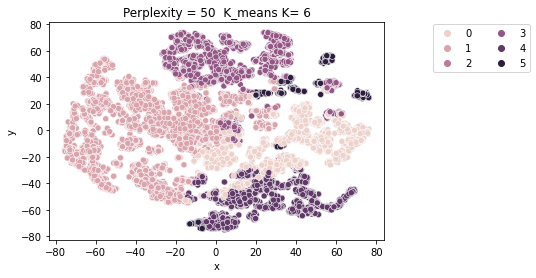

In [166]:
sns.scatterplot(x='x', y='y', hue= 'K_means6', data=dff)
plt.title('Perplexity = '+ str(50) + '  K_means K= 6' )
plt.legend(loc= 'lower right', ncol= 2,bbox_to_anchor=(1.45, 0.75))
plt.show()

In [170]:
dff.loc[dff['K_means3'] == 0, ]['Category'].value_counts()

en:sugary-snacks                      2451
en:plant-based-foods-and-beverages    1847
en:salty-snacks                        550
en:beverages                           241
en:sweeteners                          120
                                      ... 
fr:produits-sous-licence                 1
de:chips                                 1
fr:boisson-isotonique                    1
pt:bolachas                              1
fr:udon                                  1
Name: Category, Length: 198, dtype: int64

In [171]:
dff.loc[dff['K_means3'] == 1, ]['Category'].value_counts()

en:plant-based-foods-and-beverages       2257
en:beverages                             1579
en:dairies                                973
en:meats                                  867
en:groceries                              841
                                         ... 
fr:canard-laque-aux-champignons-noirs       1
fr:petit-suisse-nature                      1
fr:pates-cuisinees                          1
en:yaourt                                   1
fr:sauces-au-poisson                        1
Name: Category, Length: 357, dtype: int64

In [172]:
dff.loc[dff['K_means3'] == 2, ]['Category'].value_counts()

en:dairies                            693
en:plant-based-foods-and-beverages    431
en:meats                              411
en:fresh-foods                        312
en:sugary-snacks                      273
                                     ... 
en:beef-jerky                           1
fr:glacage                              1
fr:cremes-brulees                       1
en:chocolate-with-raspberries           1
en:foies-gras                           1
Name: Category, Length: 93, dtype: int64

In [173]:
dff.loc[dff['K_means6'] == 0, ]['Category'].value_counts()

en:plant-based-foods-and-beverages    1811
en:sugary-snacks                       778
en:salty-snacks                        587
en:groceries                            73
en:sandwiches                           54
                                      ... 
fr:aromates                              1
fr:graine-de-couscous                    1
en:green-olives                          1
en:flour-tortillas                       1
en:cinnamon-raisin-bagels                1
Name: Category, Length: 138, dtype: int64

In [175]:
dff.loc[dff['K_means6'] == 1, ]['Category'].value_counts()

en:plant-based-foods-and-beverages    1760
en:beverages                          1575
en:dairies                             946
en:groceries                           799
en:meals                               725
                                      ... 
en:plats-prepares                        1
en:non-food-products                     1
fr:nappages                              1
fr:melanges-de-legumes-en-conserve       1
fr:sauces-au-poisson                     1
Name: Category, Length: 261, dtype: int64

In [176]:
dff.loc[dff['K_means6'] == 2, ]['Category'].value_counts()

en:groceries         37
en:dairies            3
en:salty-snacks       1
en:food-additives     1
Name: Category, dtype: int64

In [177]:
dff.loc[dff['K_means6'] == 3, ]['Category'].value_counts()

en:meats                              1235
en:dairies                             665
en:fresh-foods                         492
en:plant-based-foods-and-beverages     295
en:seafood                             253
                                      ... 
es:avec                                  1
en:chicken-pies                          1
it:prosciutto-cotto                      1
fr:paupiettes-de-porc                    1
en:pork-ham                              1
Name: Category, Length: 136, dtype: int64

In [178]:
dff.loc[dff['K_means6'] == 4, ]['Category'].value_counts()

en:sugary-snacks                                             1803
en:plant-based-foods-and-beverages                            461
en:beverages                                                  223
en:sweeteners                                                 115
en:spreads                                                     91
                                                             ... 
fr:baies                                                        1
fr:biscuits-fourres-au-lait-et-nappes-de-chocolat-au-lait       1
fr:bonbon-drageifie                                             1
en:chocolate-mints                                              1
fr:pepites-de-chocolat-noir                                     1
Name: Category, Length: 107, dtype: int64

In [179]:
dff.loc[dff['K_means6'] == 5, ]['Category'].value_counts()

en:plant-based-foods-and-beverages    208
en:sugary-snacks                      139
en:fats                               112
en:spreads                            107
en:fish-and-meat-and-eggs              78
en:groceries                           76
en:dairies                             52
en:fresh-foods                         44
en:canned-foods                        18
en:salty-snacks                        13
en:meats                               11
en:seafood                              5
en:beverages                            3
en:black-truffle-oil                    2
fr:bouchees                             2
de:schlagsahne                          2
en:bruschetta                           1
fr:oignons-frits                        1
en:cremes-fraiches-epaisses             1
en:pecans                               1
en:chips                                1
en:foies-gras                           1
pt:manteigas                            1
fr:fromage-a-pate-molle           

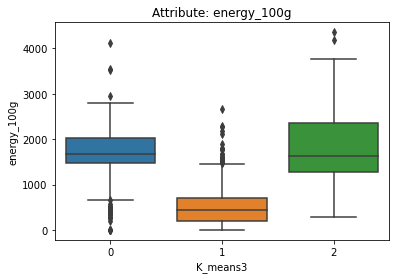

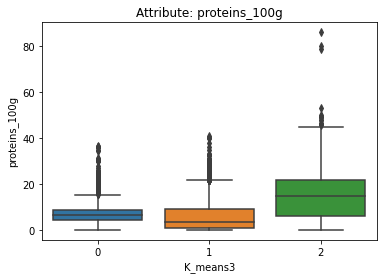

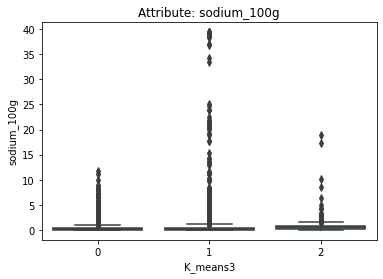

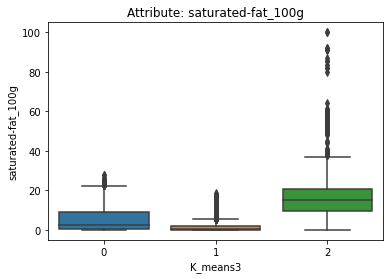

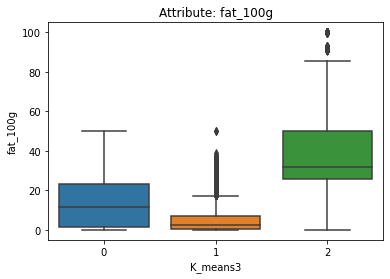

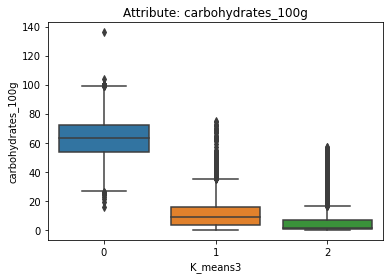

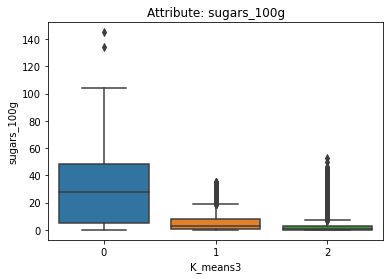

In [181]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='K_means3', y=col, data=dff)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

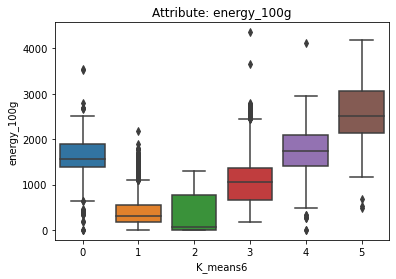

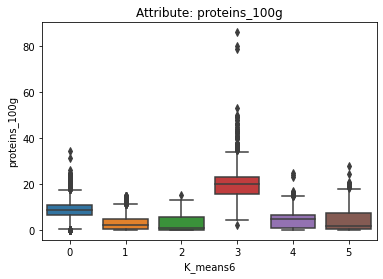

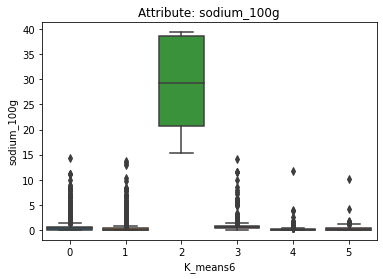

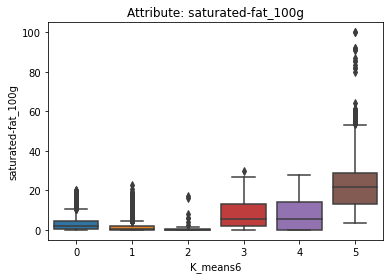

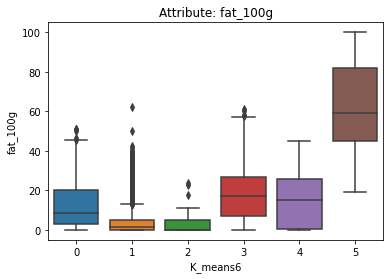

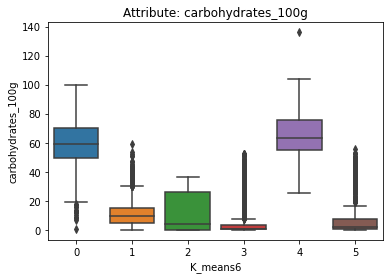

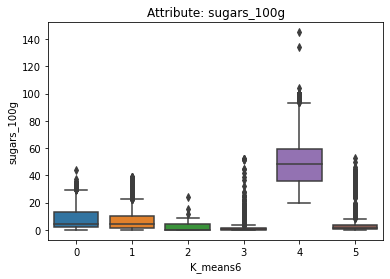

In [182]:
for col in ["energy_100g","proteins_100g","sodium_100g", 'saturated-fat_100g',\
             "fat_100g","carbohydrates_100g","sugars_100g"]:
  sns.boxplot(x='K_means6', y=col, data=dff)
  plt.title('Attribute: %s' %col)
  plt.ylabel(col)
  plt.show()

### Try Hierarchical Clustering

In [183]:
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet, ward

In [ ]:
# Show the truncated dendrogram for a complete linkage
dm = pdist(sdf, metric='euclidean')
Z = linkage(dm, method='ward')

fig, ax = plt.subplots(figsize=(25, 20))

d = dendrogram(Z, orientation='right', truncate_mode='lastp', p=80, no_labels=True, ax=ax)

ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Samples (80 leaves)', fontsize=18)

plt.show()


In [185]:
scaledX

,energy_100g,proteins_100g,sodium_100g,saturated-fat_100g,fat_100g,carbohydrates_100g,sugars_100g
0,-1.076674,-0.943235,-0.242319,-0.611039,-0.738719,-0.457050,0.054700
1,0.725089,-0.943235,-0.257106,-0.611039,-0.738719,2.474010,4.377407
2,-1.322369,-0.930189,-0.256866,-0.599253,-0.733231,-0.979528,-0.677502
3,1.457210,-0.330076,-0.235456,1.875752,1.089035,1.010333,2.110291
4,0.249831,-0.434443,-0.208994,-0.186752,-0.354507,1.025155,1.703512
...,...,...,...,...,...,...,...
19995,0.323043,-0.904097,-0.254701,-0.563896,-0.711276,1.981177,3.656052
19996,-1.185871,-0.799729,0.108549,-0.599253,-0.694809,-0.898006,-0.655807
19997,-0.481050,1.065839,0.108549,-0.504967,-0.294131,-0.835013,-0.531062
19998,0.686622,0.048256,-0.124797,-0.563896,-0.579546,1.955238,-0.634113


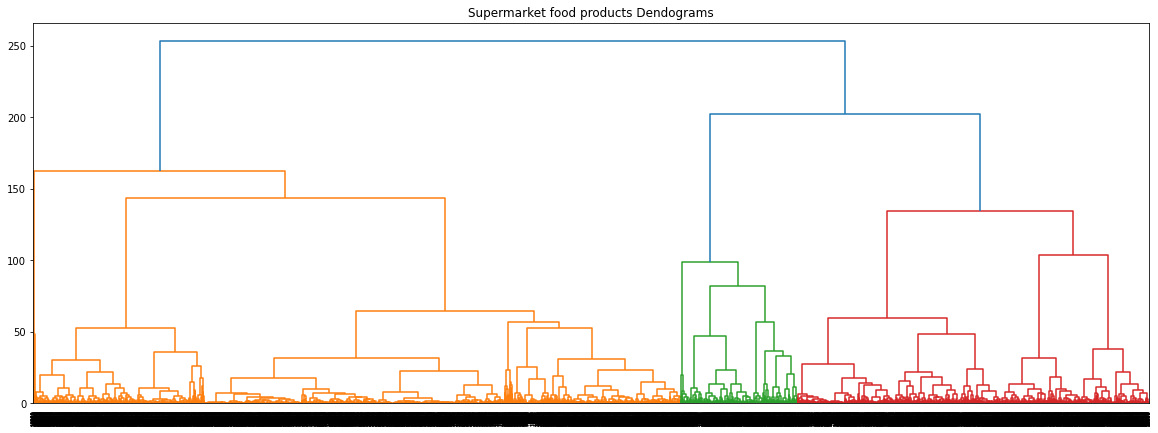

In [186]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 7))
plt.title("Supermarket food products Dendograms")
plt.xticks(rotation='vertical')


dend = shc.dendrogram(shc.linkage(scaledX, method='ward'))

In [189]:
agc = AgglomerativeClustering(n_clusters=6, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward')

dff['hierarchical6'] = agc.fit_predict(scaledX)


In [191]:
dff['hierarchical6'].value_counts()

1    8547
5    3658
4    3020
0    2644
2    2090
3      41
Name: hierarchical6, dtype: int64

In [193]:
dff.loc[dff['hierarchical6'] == 0, ]['Category'].value_counts()

en:sugary-snacks                         1661
en:plant-based-foods-and-beverages        312
en:beverages                              217
en:sweeteners                             113
en:spreads                                 87
                                         ... 
en:hot-cocoa-mix                            1
en:milk-chocolate-filled-with-caramel       1
fr:boisson-au-cafe                          1
en:brownie                                  1
fr:pepites-de-chocolat-noir                 1
Name: Category, Length: 92, dtype: int64

In [194]:
dff.loc[dff['hierarchical6'] == 1, ]['Category'].value_counts()

en:plant-based-foods-and-beverages    1889
en:beverages                          1569
en:dairies                             880
en:groceries                           852
en:meals                               690
                                      ... 
en:maris-piper-potatoes                  1
en:non-food-products                     1
fr:nappages                              1
fr:melanges-de-legumes-en-conserve       1
fr:sauces-au-poisson                     1
Name: Category, Length: 266, dtype: int64

In [195]:
dff.loc[dff['hierarchical6'] == 2, ]['Category'].value_counts ()

en:dairies                            646
en:plant-based-foods-and-beverages    383
en:fresh-foods                        253
en:meats                              134
en:spreads                            132
en:fats                               132
en:sugary-snacks                      129
en:groceries                           88
en:fish-and-meat-and-eggs              78
en:beverages                           19
en:canned-foods                        17
en:salty-snacks                        11
en:goat-milk-cheese                     8
en:seafood                              5
en:meals                                4
fr:fromage-a-pate-molle                 2
en:feta-cheese                          2
en:breakfasts                           2
en:snacks                               2
en:chorizo                              2
en:black-truffle-oil                    2
de:schlagsahne                          2
pt:manteigas                            1
es:lacteosas                      

In [196]:
dff.loc[dff['hierarchical6'] == 3, ]['Category'].value_counts()

en:groceries         36
en:dairies            3
en:salty-snacks       1
en:food-additives     1
Name: Category, dtype: int64

In [197]:
dff.loc[dff['hierarchical6'] == 4, ]['Category'].value_counts()

en:meats                                     1121
en:fresh-foods                                336
en:canned-foods                               270
en:seafood                                    267
en:plant-based-foods-and-beverages            181
                                             ... 
fr:miettes-de-thon-a-l-huile-de-tournesol       1
en:venison                                      1
fr:bouchees-au-fromage                          1
en:beef-jerky                                   1
en:chicken-pies                                 1
Name: Category, Length: 139, dtype: int64

In [198]:
dff.loc[dff['hierarchical6'] == 5, ]['Category'].value_counts()

en:plant-based-foods-and-beverages    1770
en:sugary-snacks                       880
en:salty-snacks                        587
en:breakfasts                           59
en:pie-dough                            44
                                      ... 
fr:macarons                              1
fr:feculents                             1
fr:fajitas                               1
en:corn-tortilla-chips                   1
en:sweet-olives                          1
Name: Category, Length: 133, dtype: int64